In [58]:
%load_ext autoreload
%autoreload 2
import torch
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import my_scripts
import torch.optim as optim
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import tqdm
import autoencoder
import torch.nn as nn
from sklearn.model_selection import train_test_split

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [59]:
SEED = 10
MSA_length = 202
AA_latent = 80
latent_dim = 100

In [60]:
N = 18000

# Les fichiers d'alignements doivent être dans un dossier "data/" et sous la forme X_has_L1, ..., X_has_Ln
# avec Li le label numéro i
Xu, Y, labels = my_scripts.generation_dataset(N, SEED)

indices = np.random.choice(Xu.shape[0], N, replace=False)

Xu_subset = Xu[indices]
Y_subset = Y[indices]

Xu_train, Xu_test, Ytrain, Ytest = train_test_split(Xu_subset, Y_subset, train_size=0.8, random_state=SEED)

Xu_train = torch.tensor(Xu_train, dtype=torch.float32)
Xu_test = torch.tensor(Xu_test, dtype=torch.float32)

batch_size = 256

dataset_train = TensorDataset(Xu_train)
dataset_test = TensorDataset(Xu_test)


dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, drop_last=False)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=True, drop_last=False)

print(len(dataloader_train))

57


In [61]:
AE_v1 = autoencoder.Autoencoder_v1(taille=MSA_length, AA_latent=AA_latent, latent_dim=latent_dim, dropout_rate=0.3)
#AE_v2 = autoencoder.Autoencoder_v2(taille=MSA_length, AA_latent=AA_latent, latent_dim=latent_dim, dropout_rate=0.3)
#AE_v1.load_state_dict(torch.load('modele/ae_v1.pth'))

In [62]:
criterion = nn.BCELoss() # reduction="sum"
optimizer_v1 = optim.Adam(AE_v1.parameters(), lr=0.001)
#optimizer_v2 = optim.Adam(AE_v2.parameters(), lr=0.001)

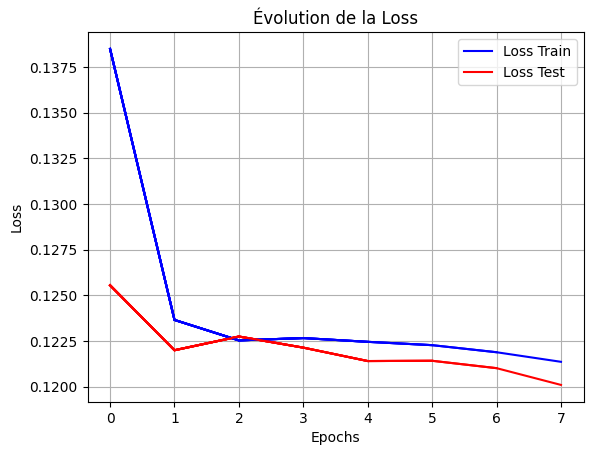

 10%|█         | 8/80 [08:58<1:21:52, 68.23s/it]

In [ ]:
num_epochs = 80
pas = 1

loss_train, loss_test = [], []

plt.figure()

c = 0

for epoch in tqdm.tqdm(range(num_epochs)):
    epoch_loss_train = 0.0
    epoch_loss_test = 0.0
    
    for batch in dataloader_train:
        X_batch = batch[0].to(torch.float32)
        reconstructed = AE_v1(X_batch)
        loss = criterion(reconstructed, X_batch)
        optimizer_v1.zero_grad()
        loss.backward()
        optimizer_v1.step()
        epoch_loss_train += loss.item()

    if c % pas == 0:
        for batch in dataloader_test:
            X_batch = batch[0].to(torch.float32)
            reconstructed = AE_v1(X_batch)
            loss = criterion(reconstructed, X_batch)
            epoch_loss_test += loss.item()

        loss_train.append(epoch_loss_train / len(dataloader_train))
        loss_test.append(epoch_loss_test / len(dataloader_test))

        clear_output(wait=True)
        plt.plot(loss_train, label="Loss Train", color="blue")
        plt.plot(loss_test, label="Loss Test", color="red")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.title("Évolution de la Loss")
        if c == 0:
            plt.legend()
            plt.grid()
        display(plt.gcf())

    c += 1

plt.show()


In [57]:
# AE_v1

H = []

for seq in Xu_test:
    reconstructed = AE_v1(seq.unsqueeze(0))[0]
    reconstructed = "".join(my_scripts.indice_to_AA[int(torch.argmax(bloc))] for bloc in reconstructed.view(-1, 21))
    label = "".join(my_scripts.indice_to_AA[int(torch.argmax(bloc))] for bloc in seq.view(-1, 21))
    hamming = sum(c1 != c2 for c1, c2 in zip(label, reconstructed))/len(label) * 100
    H.append(hamming)

print(f"Test: {round(np.mean(H), 3)}% d'erreur")

H = []

for seq in Xu_train:
    reconstructed = AE_v1(seq.unsqueeze(0))[0]
    reconstructed = "".join(my_scripts.indice_to_AA[int(torch.argmax(bloc))] for bloc in reconstructed.view(-1, 21))
    label = "".join(my_scripts.indice_to_AA[int(torch.argmax(bloc))] for bloc in seq.view(-1, 21))
    hamming = sum(c1 != c2 for c1, c2 in zip(label, reconstructed))/len(label) * 100
    H.append(hamming)

print(f"Train: {round(np.mean(H), 3)}% d'erreur")

Test: 18.496% d'erreur
Train: 15.82% d'erreur


In [28]:
H = []

for seq in tqdm.tqdm(torch.tensor(Xu, dtype=torch.float32)):
    reconstructed = AE_v1(seq.unsqueeze(0))[0]
    reconstructed = "".join(my_scripts.indice_to_AA[int(torch.argmax(bloc))] for bloc in reconstructed.view(-1, 21))
    label = "".join(my_scripts.indice_to_AA[int(torch.argmax(bloc))] for bloc in seq.view(-1, 21))
    hamming = sum(c1 != c2 for c1, c2 in zip(label, reconstructed))/len(label) * 100
    H.append(hamming)

print(f"Dataset de {Xu.shape[0]} exemples: {round(np.mean(H), 3)}")

100%|██████████| 18000/18000 [02:02<00:00, 147.12it/s]

Dataset de 18000 exemples: 35.559


In [41]:
torch.save(AE_v1.state_dict(), 'modele/ae_v1.pth')